In [304]:
#import everything needed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.signal import find_peaks
from scipy.stats import norm
import scipy.signal
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [305]:
#loading the file
file_path = 'output25-55-OR.csv'

#make it a pandas file for easier data analysis
data_all_channels = pd.read_csv(file_path)

#the data is given in 4 channels, and are only interested in channel 1 and channel
data_ch1_unnormalized = data_all_channels.iloc[0::4].reset_index(drop=True)
data_ch2_unnormalized = data_all_channels.iloc[1::4].reset_index(drop=True)
data_ch3_unnormalized = data_all_channels.iloc[2::4].reset_index(drop=True)
data_ch4_unnormalized = data_all_channels.iloc[3::4].reset_index(drop=True)

#we take channel 2 as baseline
data_ch2 = data_ch2_unnormalized 
# alles omzetten naar één lang array per kanaal en dan gemiddelde nemen
mean_ch1 = data_ch1_unnormalized.select_dtypes(include='number').values.flatten().mean()
mean_ch2 = data_ch2_unnormalized.select_dtypes(include='number').values.flatten().mean()
mean_ch3 = data_ch3_unnormalized.select_dtypes(include='number').values.flatten().mean()
mean_ch4 = data_ch4_unnormalized.select_dtypes(include='number').values.flatten().mean()

# multipliers berekenen (ten opzichte van channel 2)
mult_ch1 = mean_ch2 / mean_ch1
mult_ch3 = mean_ch2 / mean_ch3
mult_ch4 = mean_ch2 / mean_ch4

print(mult_ch1, mult_ch3, mult_ch4)
#normalize channel 1
data_ch1 = data_ch1_unnormalized.copy()
number_columns = data_ch1.select_dtypes(include='number').columns
data_ch1[number_columns] = data_ch1[number_columns] * mult_ch1 #place here the multiplier to multiplier channel 1

#normalize channel 3
data_ch3 = data_ch3_unnormalized.copy()
number_columns = data_ch3.select_dtypes(include='number').columns
data_ch3[number_columns] = data_ch3[number_columns] *mult_ch3  #place here the multiplier to multiplier channel 3

#normalize channel 4
data_ch4 = data_ch4_unnormalized.copy()
number_columns = data_ch4.select_dtypes(include='number').columns
data_ch4[number_columns] = data_ch4[number_columns] *mult_ch4

0.9825883349333686 1.0594960876133435 1.2422461444946682


In [306]:
channels = [data_ch1, data_ch2, data_ch3, data_ch4]
def plot_pulse(row, channel):
    pulse_data = channel.iloc[row, 2:].astype(float)
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(pulse_data)), pulse_data, label="Pulse Data", color="blue")
    plt.title(f"Pulse Data for Row {row}")
    plt.xlabel("Time (arbitrary units)")
    plt.ylabel("Amplitude (mV)")
    plt.legend()
    plt.grid()
    plt.show()

#for i, ch in enumerate(channels, start=1):
    #print(f"Channel {i}")
    #plot_pulse(2, ch)  # Change the row index as needed

In [307]:
def baseline_adjustment(pulse_data, first_samples=50):
    """Provides a baseline adjusted pulse from a given value of first samples, default 50"""
    # calculate the baseline using the specified number of first samples
    baseline_samples = pulse_data[:first_samples]
    baseline_avg = baseline_samples.mean()

    # adjust the pulse to return to zero
    adjusted_pulse = pulse_data - baseline_avg

    return adjusted_pulse

def get_adjusted_pulse(data, row):
    """Get the baseline adjusted pulse for a row"""
    pulse_data = data.iloc[row, 2:].astype(float)

    adjusted_pulse = baseline_adjustment(pulse_data, 50)

    return adjusted_pulse

Channel 1


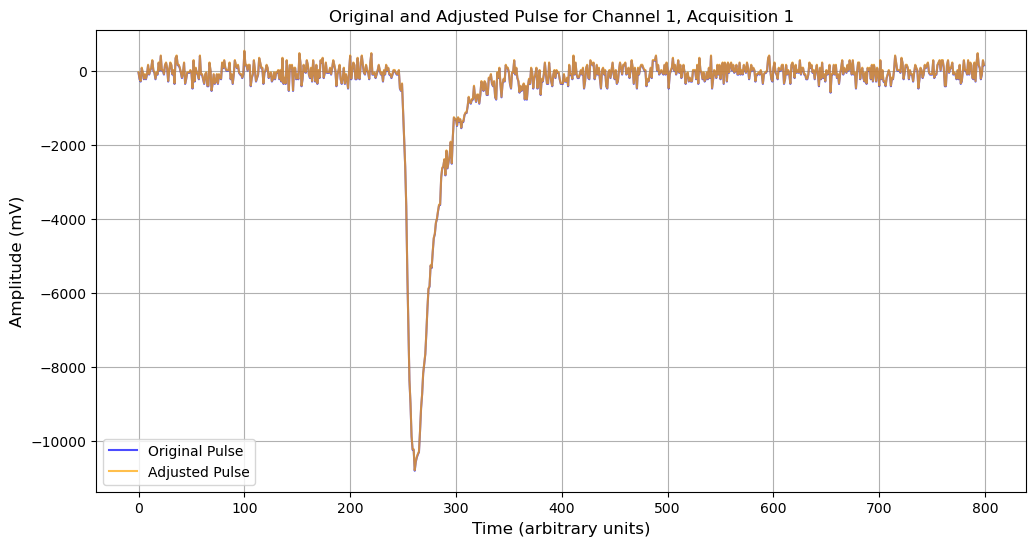

Channel 2


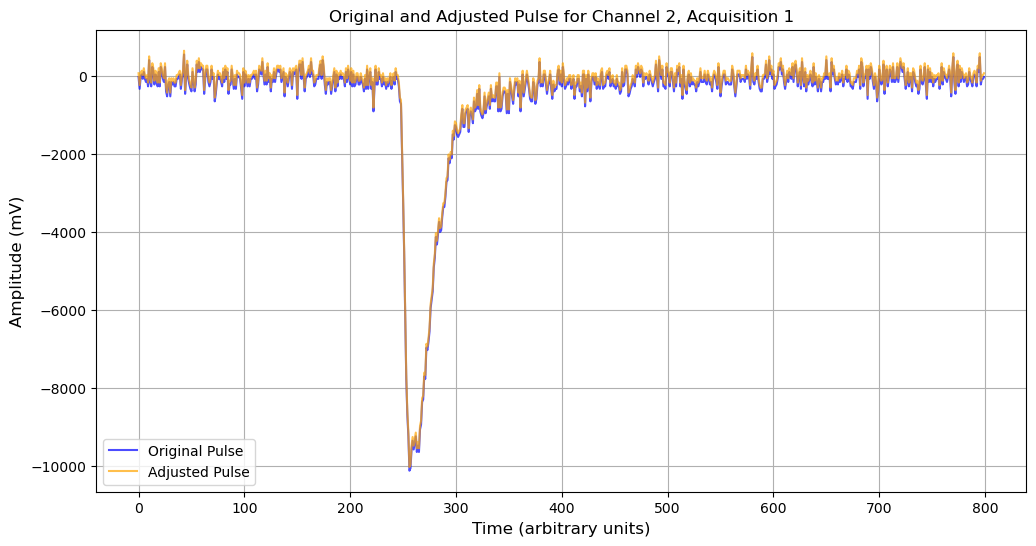

Channel 3


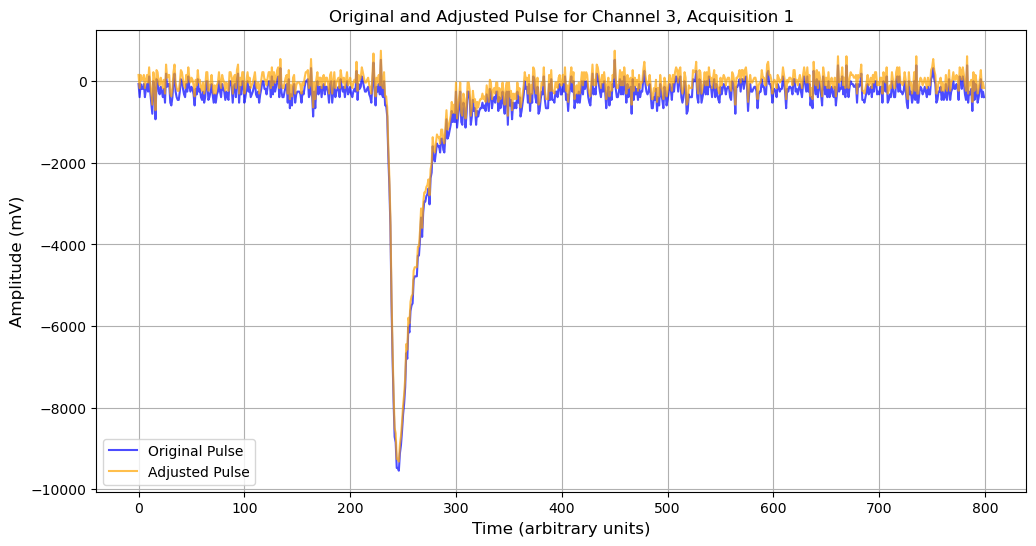

Channel 4


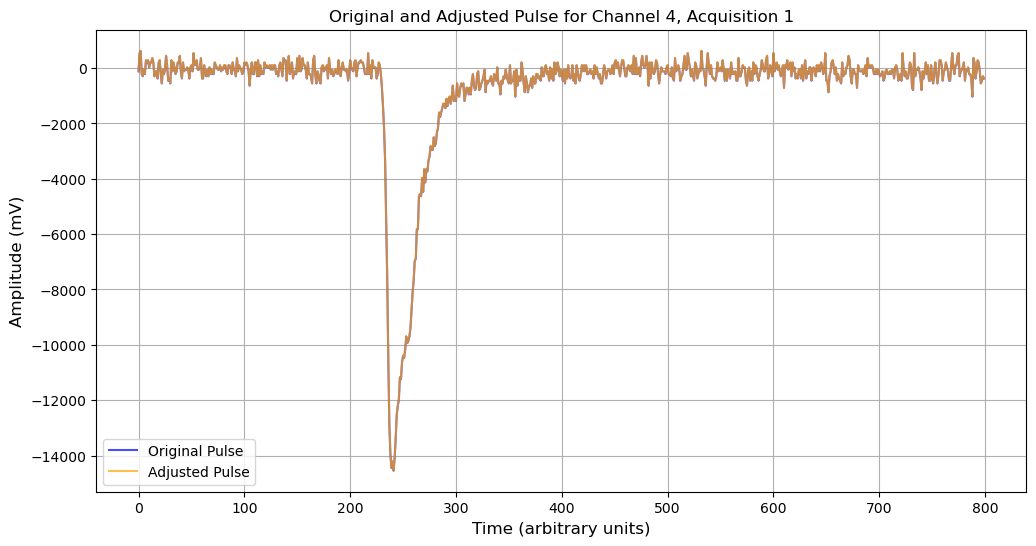

In [308]:
row = 1
for i, ch in enumerate(channels, start=1):
    print(f"Channel {i}") 
    pulse_data = ch.iloc[row, 2:].astype(float) 
    adjusted_pulse = get_adjusted_pulse(ch, row) 
    plt.figure(figsize=(12, 6)) 
    plt.plot(range(len(pulse_data)), pulse_data, label="Original Pulse", alpha=0.7, color="blue")
    plt.plot(range(len(adjusted_pulse)), adjusted_pulse, label="Adjusted Pulse", alpha=0.7, color="orange")
    plt.title(f"Original and Adjusted Pulse for Channel {i}, Acquisition {row}")
    
    plt.xlabel("Time (arbitrary units)", fontsize=12)
    plt.ylabel("Amplitude (mV)", fontsize=12)
    plt.legend()
    plt.grid()
    plt.show()

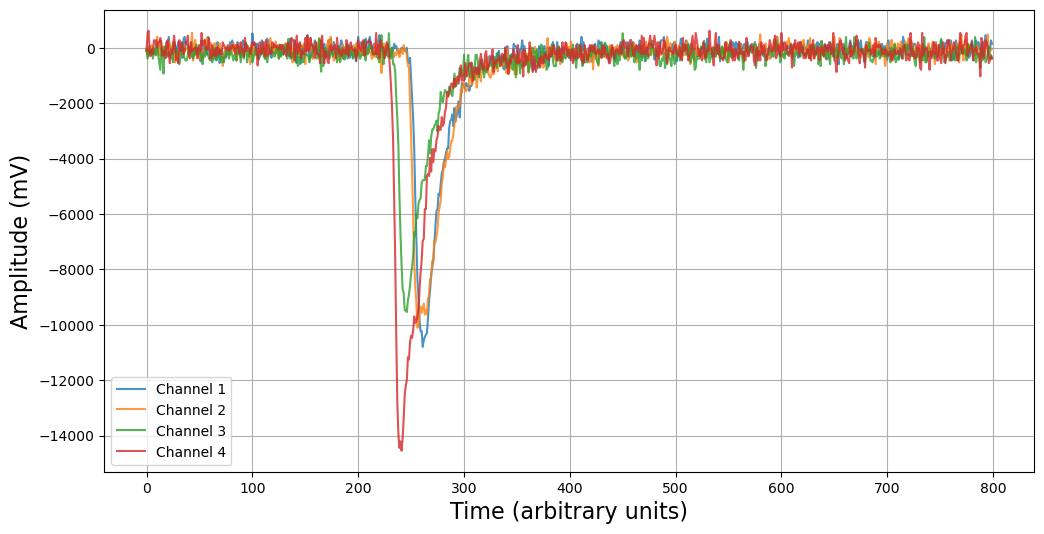

In [309]:

plt.figure(figsize=(12, 6))

for i, ch in enumerate(channels, start=1):
    pulse_data = ch.iloc[row, 2:].astype(float)
    plt.plot(range(len(pulse_data)), pulse_data, label=f"Channel {i}", alpha=0.8)

#plt.xlim(0,50)
plt.xlabel("Time (arbitrary units)", fontsize=16)
plt.ylabel("Amplitude (mV)", fontsize=16)
#plt.title("Original Pulses (all channels)", fontsize=14)
plt.legend()
plt.grid()
plt.show()#


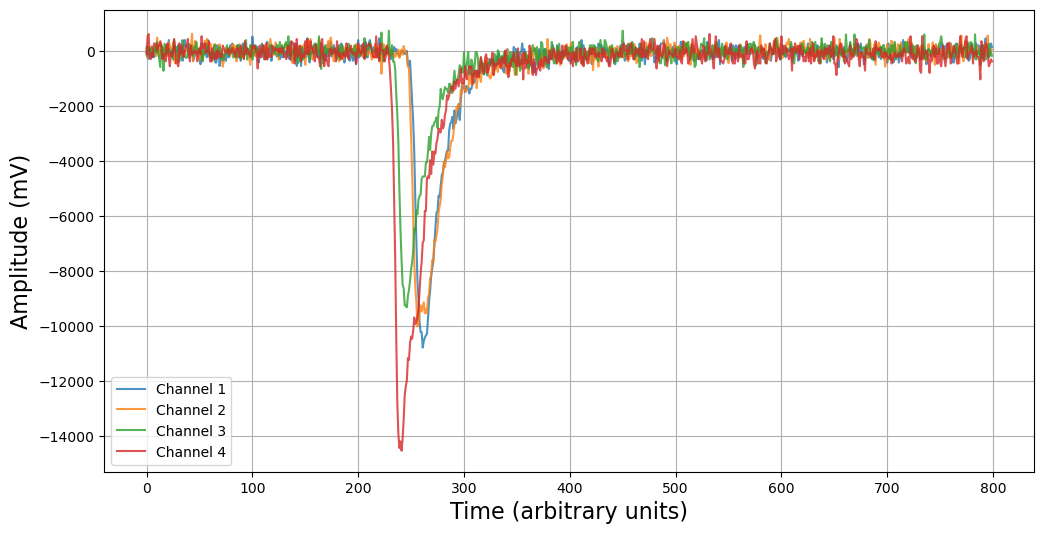

In [310]:
plt.figure(figsize=(12, 6))

for i, ch in enumerate(channels, start=1):
    adjusted_pulse = get_adjusted_pulse(ch, row)
    plt.plot(range(len(adjusted_pulse)), adjusted_pulse, label=f"Channel {i}", alpha=0.8)

plt.xlabel("Time (arbitrary units)", fontsize=16)
plt.ylabel("Amplitude (mV)", fontsize=16)
#plt.title("Adjusted Pulses (all channels)", fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [311]:
#function on how to find the bottom of the pulse
#this function finds the index and value of the minimum point of the pulse
def find_pulse_bottom(pulse_data):
    """Provides the index and value of the minimum point of the pulse"""
    index = np.argmin(pulse_data)
    value = pulse_data.iloc[index]
    top_index = np.argmax(pulse_data)
    return index, value, top_index

    
#function on how to find the integral of the pulse
#this function finds the area of the pulse by determining the zero crossing points
#it does this by looking for the first point above zero on the left and right side of the pulse
#it then takes the 2 points prior and the 2 points after and does a linear interpolation to find the exact zero crossing point
#finally it integrates the pulse between the two zero crossing points and returns the area
def find_baseline_area(pulse_data, bottom_index, threshold=0):
    """"Finds the area of the pulse by determining the zero crossing points"""
    left_index_2 = None
    left_index_3 = None
    right_index_2 = None
    right_index_3 = None

    #start at the peak and do 1 step to the left every time and when the value gets above 0,
    # save the 2 point prior and the 2 points after
    for i in range(bottom_index, -1, -1):
        if pulse_data.iloc[i] > threshold:
            left_index_1 = i - 1
            left_index_2 = i
            left_index_3 = i + 1
            left_index_4 = i + 2
            break

    #start at the peak and do 1 step to the right every time and when the value gets above 0,
    #  save the 2 point prior and the 2 points after
    for j in range(bottom_index, len(pulse_data)):
        if pulse_data.iloc[j] > threshold:
            right_index_1 = j - 2
            right_index_2 = j - 1
            right_index_3 = j
            right_index_4 = j + 1
            break

    #interpolation is only done with the first point before the crossing and the point after the crossing.
    needed_indices = [left_index_2, left_index_3, right_index_2, right_index_3]

    #some pulses do not cross the zero on the right side and we want to filter them out by returning none
    if any(index is None or index < 0 or index >= len(pulse_data) for index in needed_indices):
        return None, None, 0

    # interpolation and determining the zero crossing
    y_left = [pulse_data.iloc[left_index_2], pulse_data.iloc[left_index_3]]
    x_left = [left_index_2, left_index_3]
    a_left, b_left = np.polyfit(x_left, y_left, 1)
    zero_point_left_side = (b_left / -a_left)

    y_right = [pulse_data.iloc[right_index_2], pulse_data.iloc[right_index_3]]
    x_right = [right_index_2, right_index_3]
    a_right, b_right = np.polyfit(x_right, y_right, 1)
    zero_point_right_side = (b_right / -a_right)

    #integral of the pulse
    integrated_part = pulse_data[int(zero_point_left_side):int(zero_point_right_side)]

    #determine the area
    area = np.trapz(integrated_part)
    return zero_point_left_side, zero_point_right_side, area


In [312]:
# Now we can loop over all channels and rows to get the integral results
# We will store the results in a list of dictionaries and then convert it to a DataFrame
pulse_tables_df = {
    "ch1": data_ch1.iloc[:, 2:],
    "ch2": data_ch2.iloc[:, 2:],
    "ch3": data_ch3.iloc[:, 2:],
    "ch4": data_ch4.iloc[:, 2:]
}

all_records = []
integral_results = {}

for ch_name, ch_df in pulse_tables_df.items():
    print(f"(Channel {ch_name})")
    records = []
    for row in range(len(ch_df)):
        pulse = get_adjusted_pulse(ch_df, row=row)
        bottom_index, _, _ = find_pulse_bottom(pulse)
        left, right, area = find_baseline_area(pulse, bottom_index, threshold=0)
        #rise_time = bottom_index - left
        records.append({
            "channel": ch_name,
            "row": row,
            "area": -area,             # keep your sign convention
            "left_zero": left,
            "right_zero": right,
            #"rise_time": rise_time,
            "bottom_index": bottom_index
        })
    integral_results[ch_name] = pd.DataFrame(records)

#print(integral_results["rise_time"])
#rise_time_list = np.asarray(integral_results["rise_time"])
#print(integral_results["ch1"]["bottom_index"])



(Channel ch1)
(Channel ch2)
(Channel ch3)
(Channel ch4)


In [313]:
#print(integral_results["ch1"]["bottom_index"])
pulse_tables = {name: df.values  for name, df in pulse_tables_df.items()}

In [314]:
print(pulse_tables["ch1"])

[[ 141.49272023  141.49272023  267.2640271  ... -110.04989351
  -204.37837367  267.2640271 ]
 [ -62.88565344 -235.82120038 -298.70685382 ... -110.04989351
   267.2640271   141.49272023]
 [ -62.88565344 -110.04989351  -62.88565344 ...  -62.88565344
  -110.04989351   62.88565344]
 ...
 [ -62.88565344  204.37837367  -62.88565344 ...  204.37837367
   -62.88565344  455.92098741]
 [-235.82120038    0.           62.88565344 ...  204.37837367
   330.14968054    0.        ]
 [ 267.2640271   -62.88565344    0.         ... -110.04989351
   267.2640271     0.        ]]


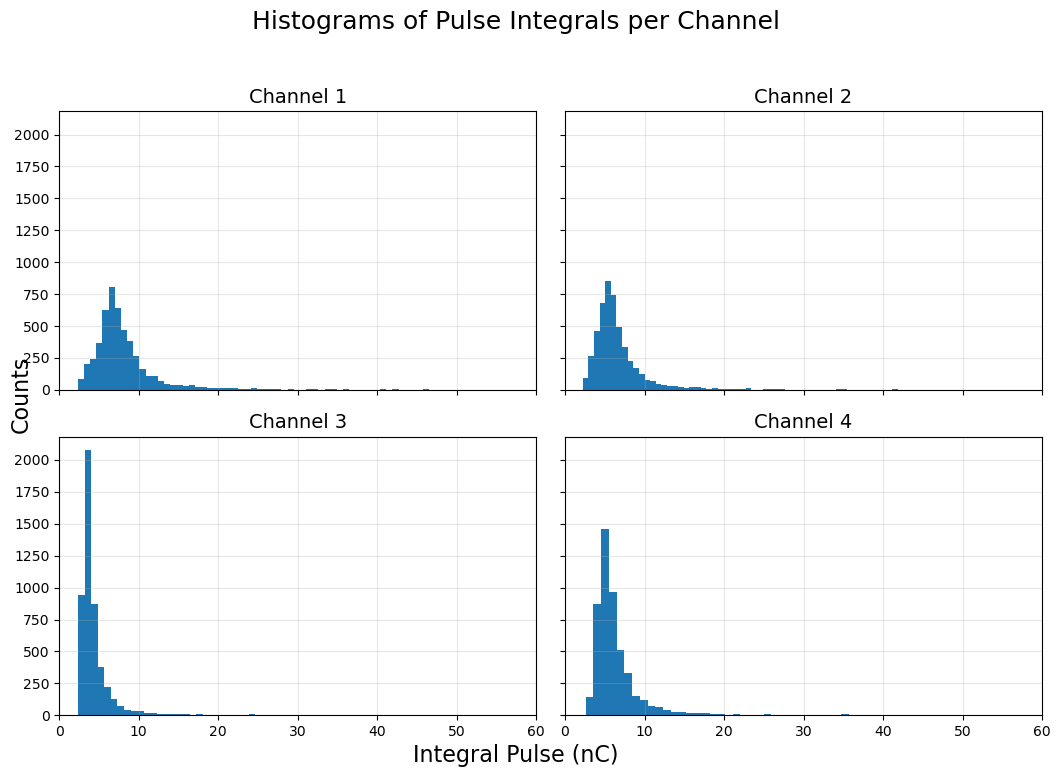

In [315]:
import numpy as np
import matplotlib.pyplot as plt

channel_names = ["ch1","ch2","ch3","ch4"]
scale = 50000.0
bins = 120  # pas aan indien gewenst

# data voorbereiden (optioneel: neem absolute waarde als je negatieve pulsen hebt)
areas = {ch: (np.asarray(integral_results[ch]["area"], float) / scale) for ch in channel_names}
# areas = {ch: (np.abs(np.asarray(results_by_channel[ch]["area"], float)) / scale) for ch in channel_names}

fig, axes = plt.subplots(2, 2, figsize=(11, 8), sharex=True, sharey=True)
axes = axes.ravel()

for ax, ch in zip(axes, channel_names):
    data = areas[ch]
    data = data[np.isfinite(data)]
    ax.hist(data, bins=bins)
    ax.set_title(f"Channel {ch[-1]}", fontsize=14)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 60)  # pas aan indien gewenst
# gezamenlijke labels
fig.text(0.5, 0.04, "Integral Pulse (nC)", ha="center", fontsize=16)
fig.text(0.04, 0.5, "Counts", va="center", rotation="vertical", fontsize=16)
fig.suptitle("Histograms of Pulse Integrals per Channel", fontsize=18)
plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
plt.show()


Channel ch1: Peak at 6.60 nC
Channel ch2: Peak at 5.74 nC
Channel ch3: Peak at 3.17 nC
Channel ch4: Peak at 4.88 nC


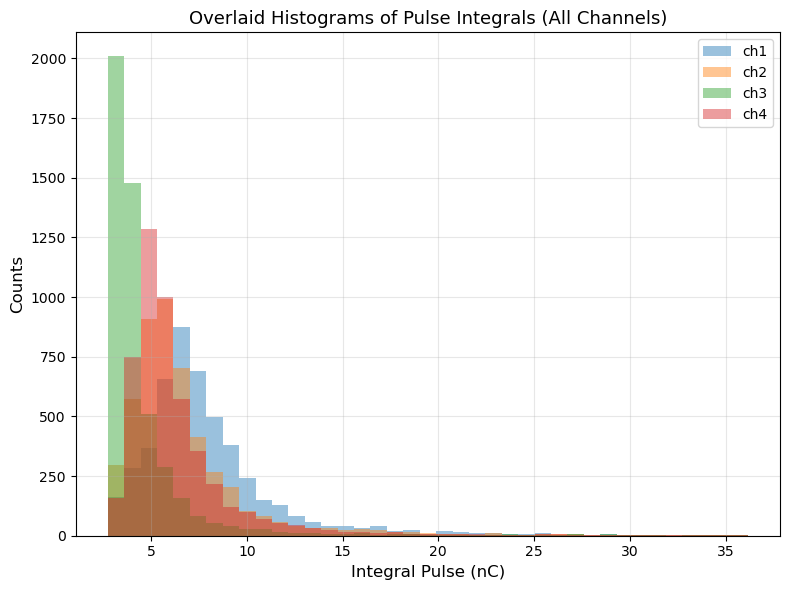

In [316]:

# areas per channel (absolute in case pulses are negative)
areas = {
    ch: np.abs(np.asarray(integral_results[ch]["area"], float)) / scale
    for ch in channel_names
}
# keep only finite
for ch in channel_names:
    areas[ch] = areas[ch][np.isfinite(areas[ch])]

# common bins from all data (use central percentile range to avoid extreme tails)
all_vals = np.concatenate([areas[ch] for ch in channel_names if areas[ch].size > 0])
lo, hi = np.percentile(all_vals, [1, 99]) if all_vals.size else (0, 1)
bins = np.linspace(lo, hi, 40)  # adjust number of bins if you like

plt.figure(figsize=(8,6))

for ch in channel_names:
    if areas[ch].size:
        counts, bins = np.histogram(areas[ch], bins=bins)
        max_index = np.argmax(counts)
        peak = (bins[max_index] + bins[max_index + 1]) / 2
        print(f"Channel {ch}: Peak at {peak:.2f} nC")
        plt.hist(areas[ch], bins=bins, alpha=0.45, label=ch)  # filled + transparent

plt.xlabel("Integral Pulse (nC)", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.title("Overlaid Histograms of Pulse Integrals (All Channels)", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


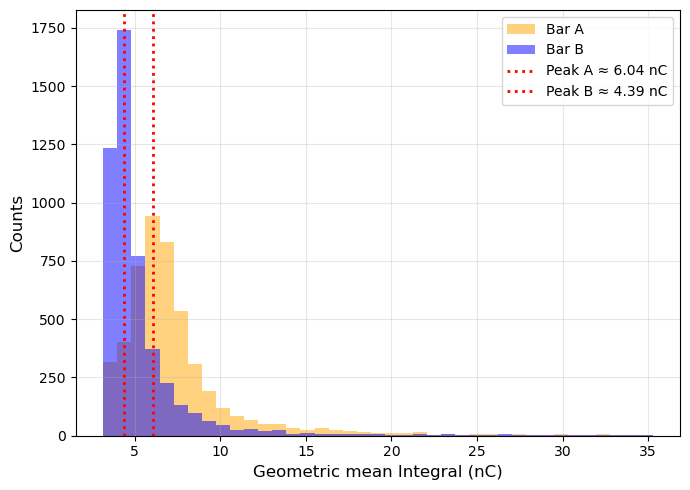

Peak bin center for Bar A: 6.04 nC
Peak bin center for Bar B: 4.39 nC


In [317]:

A1 = np.abs(np.asarray(integral_results["ch1"]["area"], float)) / scale
A2 = np.abs(np.asarray(integral_results["ch2"]["area"], float)) / scale
A3 = np.abs(np.asarray(integral_results["ch3"]["area"], float)) / scale
A4 = np.abs(np.asarray(integral_results["ch4"]["area"], float)) / scale

GA = np.sqrt(A1 * A2)   # Bar A
GB = np.sqrt(A3 * A4)   # Bar B
GA = GA[np.isfinite(GA)]
GB = GB[np.isfinite(GB)]

# Common bins from combined data
all_vals = np.concatenate([GA, GB])
bins = np.linspace(np.percentile(all_vals, 1), np.percentile(all_vals, 99), 40)

# Compute histogram counts separately
counts_A, _ = np.histogram(GA, bins=bins)
counts_B, _ = np.histogram(GB, bins=bins)

# Find peak bin index for each
peak_idx_A = np.argmax(counts_A)
peak_idx_B = np.argmax(counts_B)

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2
peak_center_A = bin_centers[peak_idx_A]
peak_center_B = bin_centers[peak_idx_B]

# Plot
plt.figure(figsize=(7,5))
plt.hist(GA, bins=bins, alpha=0.5, label="Bar A", color='orange')
plt.hist(GB, bins=bins, alpha=0.5, label="Bar B", color='blue')
plt.axvline(peak_center_A, color='red', linestyle='dotted', linewidth=2, label=f"Peak A ≈ {peak_center_A:.2f} nC")
plt.axvline(peak_center_B, color='red', linestyle='dotted', linewidth=2, label=f"Peak B ≈ {peak_center_B:.2f} nC")
plt.xlabel("Geometric mean Integral (nC)", fontsize=12)
plt.ylabel("Counts", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print peak bin centers
print(f"Peak bin center for Bar A: {peak_center_A:.2f} nC")
print(f"Peak bin center for Bar B: {peak_center_B:.2f} nC")




In [318]:
Gain_equalizer = peak_center_A / peak_center_B
print("Gain equalizer (Bar A / Bar B):", Gain_equalizer)

Gain equalizer (Bar A / Bar B): 1.3745741568769863


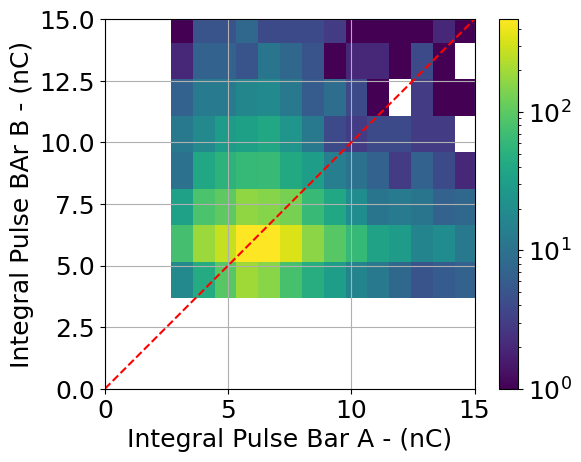

In [319]:
# Define heatmap
heatmap, xedges, yedges = np.histogram2d(GA, GB*Gain_equalizer , bins=100)

# Plot heatmap with logarithmic color scale
img = plt.imshow(
    heatmap.T, 
    origin='lower', 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
    norm=colors.LogNorm()
)

# Get colorbar and set fontsize of tick labels
cbar = plt.colorbar(img)
cbar.ax.tick_params(labelsize=18) # set fontsize of colorbar ticks

#add labels and give the text a larger fontsize
plt.xlabel(r"Integral Pulse Bar A - (nC)", fontsize=18)
plt.ylabel(r"Integral Pulse BAr B - (nC)", fontsize=18)
plt.tick_params(axis='both', labelsize=18)
plt.grid(True)
ax = plt.gca()
ax.xaxis.offsetText.set_fontsize(18)
ax.yaxis.offsetText.set_fontsize(18)

#plot the red dashed line
plt.plot([0, 2000000], [0, 2000000], color='red', linestyle='--')


# Axes limits
plt.xlim(0, 15)
plt.ylim(0, 15)

plt.show()

peak x position channel 1 = 5.7677
peak x position channel 2 = 5.6018 


In [320]:
def CFD(pulse, delay, multiplier):
    pulse = np.asarray(pulse)
    #add a zero before the code length to delay it
    delayed_pulse = np.concatenate((np.zeros(delay), pulse))
    inverted_pulse = multiplier * pulse
    #also add the zero to the code of the inverted pulse but at the end because otherwise the code is not working
    inverted_pulse_scaled = np.concatenate((inverted_pulse, np.zeros(delay)))
    CFD_pulse = delayed_pulse - inverted_pulse_scaled
    return CFD_pulse

#define the making of the pulse tables
def CFD_table(pulses, delay, multiplier):
    processed_CFD_pulses = []
    #loop over each pulse with respect to the number of the pulse in the set and apply the CFD to all of them
    for i, pulse in enumerate(pulses):
        pulse_array = np.asarray(pulse)
        result = CFD(pulse_array, delay=delay, multiplier=multiplier)
        processed_CFD_pulses.append(result)
        #and ofcourse append them and convert it into a panda dataframe
    final_table = pd.DataFrame(processed_CFD_pulses)
    return final_table

In [321]:
#best is 11 and 0.15
delay = 13
multiplier = 0.35

In [322]:
#define the crossing of the pulses with interpolation
def find_threshold_crossings(pulse_data, bottom_index_local, threshold=0):
    left_index_1 = None
    left_index_2 = None
    left_index_3 = None
    left_index_4 = None
    
    #start at the peak and do 1 step to the left every time and when the value gets above 0, save the 2 point prior and the 2 points after
    for i in range(bottom_index_local, -1, -1):
        if pulse_data.iloc[i] > threshold:
            if i + 2 < len(pulse_data) and i - 1 >= 0:
                left_index_1 = i - 1
                left_index_2 = i
                left_index_3 = i + 1
                left_index_4 = i + 2
                break
            else:
                return None
                
    right_index = None
    #check where it hits the the y=0 axis at the right side of the pulse
    for i in range(bottom_index_local, len(pulse_data)):
        if pulse_data.iloc[i] > threshold:
            right_index = i
            break

    if right_index is None:
        return None 

    #recieve the y values of the x values of the pulses
    left_voltage_1 = pulse_data.iloc[left_index_1]
    left_voltage_2 = pulse_data.iloc[left_index_2]
    left_voltage_3 = pulse_data.iloc[left_index_3]
    left_voltage_4 = pulse_data.iloc[left_index_4]
    right_voltage = pulse_data.iloc[right_index]

    #make a list with the values for interpolation
    x = [left_index_1, left_index_2, left_index_3, left_index_4]
    y = [left_voltage_1, left_voltage_2, left_voltage_3, left_voltage_4]

    #x = [left_index_2, left_index_3]
    #y = [left_voltage_2, left_voltage_3]

    #fit the linear line of best fit
    a, b = np.polyfit(x, y, 1)
    #calculate where it crosses the x-axis
    zero_point = (b / -a)

    #calculate the area
    integrated_part = pulse_data.iloc[left_index_3:right_index + 1]
    area = np.trapz(integrated_part)

    return (left_index_1, left_index_2, left_index_3, left_index_4,
            left_voltage_1, left_voltage_2, left_voltage_3, left_voltage_4, a, b, zero_point, right_index, right_voltage, area)


In [323]:
cfd_tables = {}

for name, df in pulse_tables_df.items():
    #print(f"Processing CFD for {name}")
    # df.values gives you a 2D numpy array (rows = pulses, cols = samples)
    cfd_tables[name] = CFD_table(df.values, delay=delay, multiplier=multiplier)

# Example: inspect first rows
print(len(cfd_tables["ch1"]))
print(len(cfd_tables["ch4"]))

5000
5000


In [324]:
def process_cfd_table(cfd_data, channel_name):
    records = []

    # Normalize input to 2D: (n_pulses, n_samples)
    if isinstance(cfd_data, pd.DataFrame):
        get_pulse = lambda i: cfd_data.iloc[i]
        n_pulses = len(cfd_data)
    elif isinstance(cfd_data, np.ndarray):
        arr = np.asarray(cfd_data)
        if arr.ndim == 1:
            arr = arr[None, :]
        n_pulses = arr.shape[0]
        get_pulse = lambda i: pd.Series(arr[i]).reset_index(drop=True)
    else:
        raise TypeError(f"Unsupported cfd_data type: {type(cfd_data)}")

    for i in range(n_pulses):
        pulse = get_pulse(i)
        bottom_index_local2, bottom_value, top_index = find_pulse_bottom(pulse)
        result = find_threshold_crossings(pulse, bottom_index_local2, threshold=0)

        # Default values for all fields
        record = {
            "channel": channel_name,
            "pulse_index": i,
            "bottom_index": int(bottom_index_local2),
            "top_index": int(top_index),
            "bottom_value": float(bottom_value),
            "left_cross_index_1": 0,
            "left_cross_index_2": 0,
            "left_cross_index_3": 0,
            "left_cross_index_4": 0,
            "left_cross_value_1": 0.0,
            "left_cross_value_2": 0.0,
            "left_cross_value_3": 0.0,
            "left_cross_value_4": 0.0,
            "right_index": 0,
            "right_voltage": 0.0,
            "a": 0.0,
            "b": 0.0,
            "zero_point": 0.0,
            "area": 0.0,
            "rise_time": abs(int(bottom_index_local2) - int(top_index)),
        }

        if result is not None:
            (left_index_1, left_index_2, left_index_3, left_index_4,
             left_voltage_1, left_voltage_2, left_voltage_3, left_voltage_4,
             a, b, zero_point, right_index, right_voltage, area) = result

            record.update({
                "left_cross_index_1": int(left_index_1),
                "left_cross_index_2": int(left_index_2),
                "left_cross_index_3": int(left_index_3),
                "left_cross_index_4": int(left_index_4),
                "left_cross_value_1": float(left_voltage_1),
                "left_cross_value_2": float(left_voltage_2),
                "left_cross_value_3": float(left_voltage_3),
                "left_cross_value_4": float(left_voltage_4),
                "right_index": int(right_index),
                "right_voltage": float(right_voltage),
                "a": float(a),
                "b": float(b),
                "zero_point": float(zero_point),
                "area": -float(area),
            })

        records.append(record)

    return pd.DataFrame(records)


In [325]:
# 2) CFD-features extraheren met jouw process_cfd_table
cfd_finalized = {}
for name in channel_names:
    print(f"Finalizing CFD features for {name}")
    cfd_finalized[name] = process_cfd_table(cfd_tables[name], channel_name=name)


# voorbeeld: eerste rijen van channel 1
#print(len(cfd_finalized["ch1"]))
#print(cfd_finalized["ch1"]["area"].head())
#print(cfd_finalized["ch1"]["rise_time"].head())
#cfd_finalized["ch1"] = cfd_finalized["ch1"].drop(1953)
#cfd_finalized["ch2"] = cfd_finalized["ch2"].drop(1953)
#print(len(cfd_finalized["ch1"]))

#print(len(cfd_finalized["ch4"]))

Finalizing CFD features for ch1
Finalizing CFD features for ch2
Finalizing CFD features for ch3
Finalizing CFD features for ch4


In [326]:
print(cfd_finalized["ch1"]["zero_point"][4])
print(cfd_finalized["ch2"]["zero_point"][4])    
print(cfd_finalized["ch3"]["zero_point"][4])
print(cfd_finalized["ch4"]["zero_point"][4])
print(cfd_finalized["ch1"]["bottom_index"][4999])

282.17083922481896
278.14530977855185
255.50364219114218
261.5360275689222
290


In [327]:
L= 50 #cm
dt = 0.5

c = 30 #cm/ns
s = 77#cm
tbarA_list, tbarB_list = [], []
t1_t2, t3_t4 = [], []

t1 = (cfd_finalized["ch1"]["zero_point"]*dt)-16.33 #cable length correction
t2 = (cfd_finalized["ch2"]["zero_point"]*dt)-16.33
t3 = (cfd_finalized["ch3"]["zero_point"]*dt)-10.66
t4 = (cfd_finalized["ch4"]["zero_point"]*dt)-10.66

for i in range(len(cfd_finalized["ch1"])):
    tbarA_list.append((t1[i] + t2[i]) / 2)
    t1_t2.append(t1[i] - t2[i])
    t3_t4.append(t3[i] - t4[i])
    tbarB_list.append((t3[i] + t4[i]) / 2)


tbarA = np.asarray(tbarA_list, dtype=float)
tbarB = np.asarray(tbarB_list, dtype=float)
t1_t2 = np.asarray(t1_t2, dtype=float)
t3_t4 = np.asarray(t3_t4, dtype=float)
# Pair difference (centered) → timing spread
dt_pair = tbarA - tbarB
print(len(dt_pair))


5000


In [328]:
# --- model: sum of two Gaussians scaled to histogram counts ---
def two_gauss(x, A1, mu1, sig1, A2, mu2, sig2):
    # A's are amplitudes in "counts", so include bin width in scaling
    g1 = A1 * np.exp(-0.5*((x-mu1)/sig1)**2)
    g2 = A2 * np.exp(-0.5*((x-mu2)/sig2)**2)
    return g1 + g2

Fitting 4970 entries after filtering


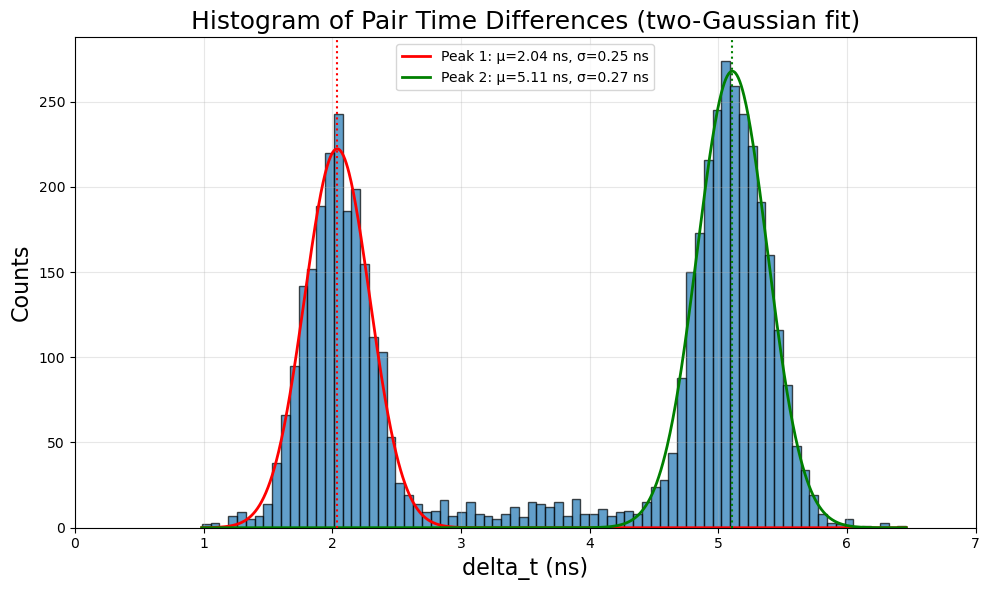

σ_pair: 0.254 ns (left), 0.273 ns (right)
Per-bar σ_t ≈ 0.186 ns


In [329]:
from scipy.optimize import curve_fit
from scipy.stats import norm

dt_pair = np.asarray(tbarA - tbarB)
#  light outlier guard
dt_pair = dt_pair[(dt_pair > np.percentile(dt_pair, 0.3)) &
                  (dt_pair < np.percentile(dt_pair, 99.7))]


print(f"Fitting {len(dt_pair)} entries after filtering")
# histogram to fit on
bins = 80
counts, edges = np.histogram(dt_pair, bins=bins)
centers = 0.5*(edges[:-1] + edges[1:])
width   = edges[1] - edges[0]

# crude initial guesses from the histogram
i1 = np.argmax(counts)
tmp = counts.copy()
mask = max(1, bins//15)
tmp[max(0, i1-mask):min(bins-1, i1+mask)] = 0
i2 = np.argmax(tmp)

mu1_0, mu2_0 = centers[min(i1,i2)], centers[max(i1,i2)]
A1_0,  A2_0  = counts[i1], counts[i2]
sig0         = 0.3  # ns, rough width guess

p0 = [A1_0, mu1_0, sig0, A2_0, mu2_0, sig0]
xfit = np.linspace(edges[0], edges[-1], 1000)
# --- fit ---
popt, pcov = curve_fit(two_gauss, centers, counts, p0=p0, maxfev=20000)
A1, mu1, s1, A2, mu2, s2 = popt


# --- plot ---
plt.figure(figsize=(10,6))
plt.hist(dt_pair, bins=bins, alpha=0.7, edgecolor="black")

#plt.plot(xfit, two_gauss(xfit, *popt), "k", lw=2, label="Sum fit")
plt.plot(xfit, A1*np.exp(-0.5*((xfit-mu1)/s1)**2), "r", lw=2,
         label=f"Peak 1: μ={mu1:.2f} ns, σ={s1:.2f} ns")
plt.plot(xfit, A2*np.exp(-0.5*((xfit-mu2)/s2)**2), "g", lw=2,
         label=f"Peak 2: μ={mu2:.2f} ns, σ={s2:.2f} ns")
plt.axvline(mu1, color='r', ls=':')
plt.axvline(mu2, color='g', ls=':')

plt.xlabel("delta_t (ns)", fontsize=16)
plt.ylabel("Counts", fontsize=16)
plt.title("Histogram of Pair Time Differences (two-Gaussian fit)", fontsize=18)
plt.xlim(0, 7)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === resolutions ===
sigma_pair_1 = s1
sigma_pair_2 = s2
# per-bar timing (assume identical bars, uncorrelated):
sigma_t_bar_1 = sigma_pair_1/np.sqrt(2)
sigma_t_bar_2 = sigma_pair_2/np.sqrt(2)
sigma_t_bar   = 0.5*(sigma_t_bar_1 + sigma_t_bar_2)  # or weighted by peak areas

print(f"σ_pair: {sigma_pair_1:.3f} ns (left), {sigma_pair_2:.3f} ns (right)")
print(f"Per-bar σ_t ≈ {sigma_t_bar:.3f} ns")


C:\Users\rutge\AppData\Local\Temp\ipykernel_24200\2611301192.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blue_cmap = get_cmap('Blues')
C:\Users\rutge\AppData\Local\Temp\ipykernel_24200\2611301192.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red_cmap = get_cmap('Reds')


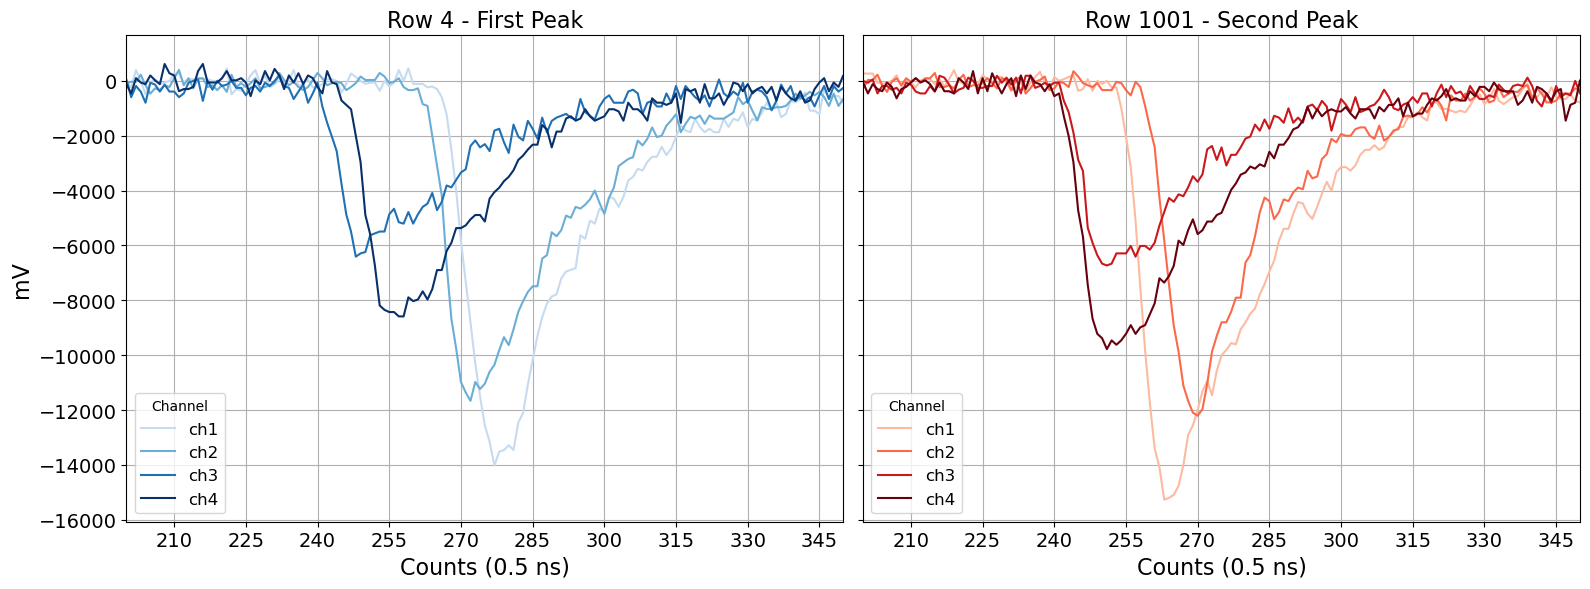

 row 4 counts of zero-point bar A 247.4980745016854, counts of zero point bar 237.1998348800322
 row 1001 counts of zero-point bar A 239.1889051711073, counts of zero point bar 235.80732168857728


In [330]:
from matplotlib.cm import get_cmap

row_idx_to_plot = [4,1001]  # First and second pulse rows
blue_cmap = get_cmap('Blues')
red_cmap = get_cmap('Reds')

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for i, row_idx in enumerate(row_idx_to_plot):
    ax = axes[i]
    cmap = blue_cmap if i == 0 else red_cmap
    for j, name in enumerate(channel_names):
        pulse = pulse_tables[name][row_idx]
        color = cmap((j + 1) / len(channel_names))
        ax.plot(pulse, label=name, color=color)

    ax.set_xlim(200, 350)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('Counts (0.5 ns)', fontsize=16)
    if i == 0:
        ax.set_ylabel('mV', fontsize=16)
    ax.grid(True)
    ax.set_title(f"Row {row_idx} - {'First' if i == 0 else 'Second'} Peak", fontsize=16)
    ax.legend(fontsize=12, title="Channel")

plt.tight_layout()
plt.savefig("baseline_adjusted_example_side_by_side", dpi=300, bbox_inches='tight')
plt.show()
print(f" row {row_idx_to_plot[0]} counts of zero-point bar A {tbarA[row_idx_to_plot[0]]*2}, counts of zero point bar {tbarB[row_idx_to_plot[0]]*2}")
print(f" row {row_idx_to_plot[1]} counts of zero-point bar A {tbarA[row_idx_to_plot[1]]*2}, counts of zero point bar {tbarB[row_idx_to_plot[1]]*2}")

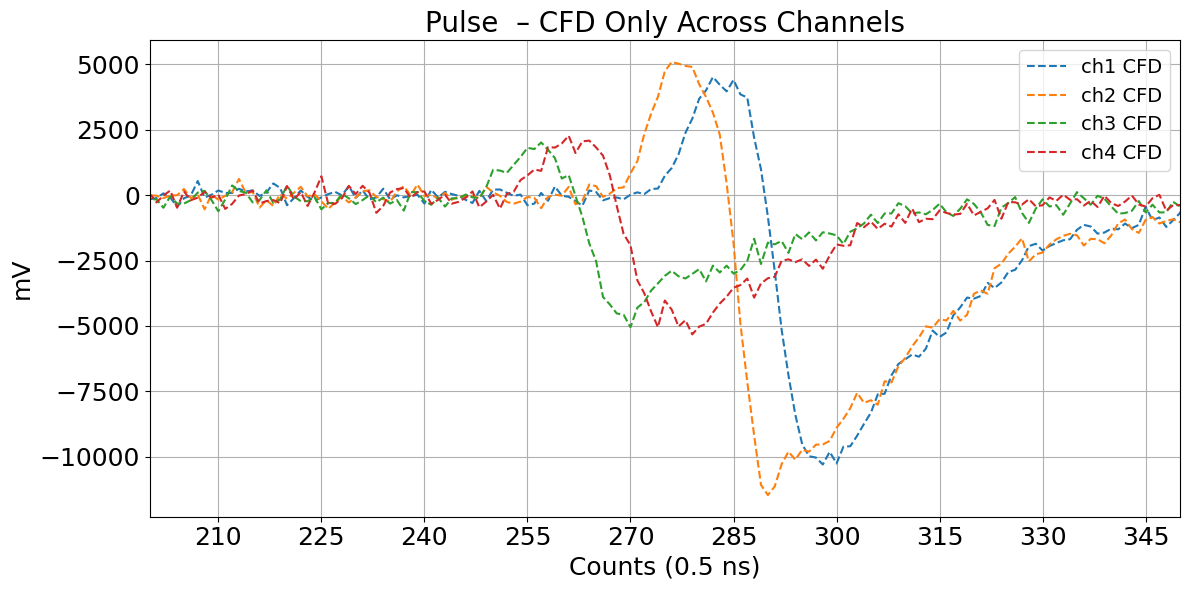

In [331]:
plt.figure(figsize=(12, 6))

for name in channel_names:
    # Extract CFD pulse for the given channel
    cfd_pulse = cfd_tables[name].iloc[0].values

    # Plot CFD pulse
    plt.plot(cfd_pulse, label=f"{name} CFD", linestyle="--")

# Formatting the plot
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
plt.tick_params(axis='both', labelsize=18)
plt.xlabel("Counts (0.5 ns)", fontsize=18)
plt.ylabel("mV", fontsize=18)
#plt.ylim(-20000, 10000)
plt.xlim(200, 350)
plt.title(f"Pulse  – CFD Only Across Channels", fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.legend(fontsize=14)
plt.savefig("cfd_all_channels", dpi=300, bbox_inches="tight")
plt.show()


(-10.0, 10.0)

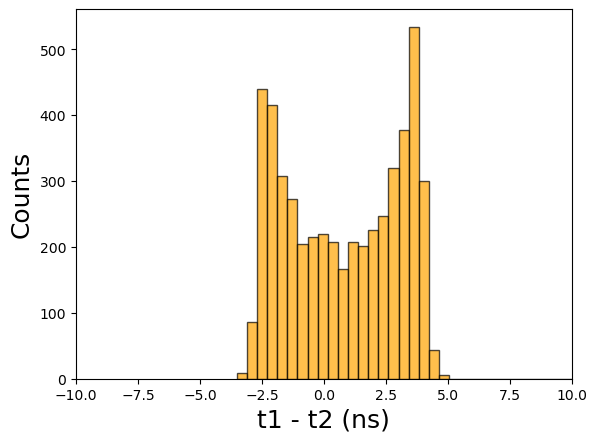

In [332]:
counts, edges = np.histogram(t1_t2, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
bin_width = edges[1] - edges[0]
plt.hist(t1_t2, bins=300, alpha=0.7, color="orange", edgecolor="black")
plt.xlabel("t1 - t2 (ns)", fontsize=18)
plt.ylabel("Counts", fontsize=18)
plt.xlim(-10, 10)

(-10.0, 10.0)

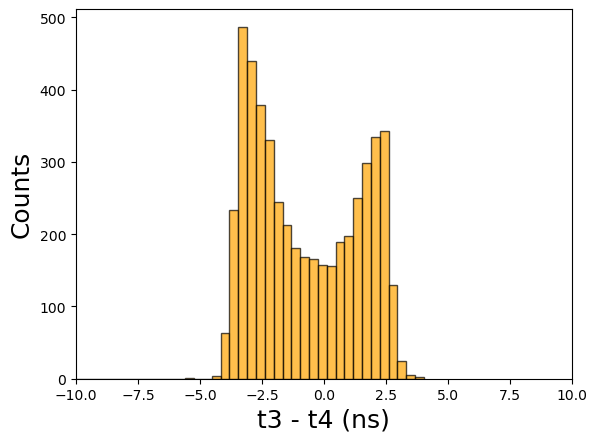

In [333]:
counts, edges = np.histogram(t3_t4, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
bin_width = edges[1] - edges[0]
plt.hist(t3_t4, bins=300, alpha=0.7, color="orange", edgecolor="black")
plt.xlabel("t3 - t4 (ns)", fontsize=18)
plt.ylabel("Counts", fontsize=18)
plt.xlim(-10, 10)

In [334]:
mask_A_first = tbarA < tbarB
indices_Afirst = np.where(mask_A_first)[0]
print(indices_Afirst)
dA = (tbarA - tbarB)[mask_A_first]
dB = (tbarA - tbarB)[~mask_A_first]
# center each class (important!) and 3σ-filter
def center_and_sigma(x):
    x = x - np.mean(x)
    mu0 = np.mean(x); sd0 = np.std(x, ddof=1)
    keep = np.abs(x - mu0) < 3*sd0
    x2 = x[keep] if keep.sum() >= 3 else x
    return np.std(x2, ddof=1), x2

sigmaA, dA_c = center_and_sigma(dA)
sigmaB, dB_c = center_and_sigma(dB)

print(f"sigma_pair (A-first) = {sigmaA:.2f} ns")
print(f"sigma_pair (B-first) = {sigmaB:.2f} ns")

# combined, centered per class → one Gaussian
dt_pair_centered = np.concatenate([dA_c, dB_c])
print(f"combined sigma_pair ≈ {np.std(dt_pair_centered, ddof=1):.2f} ns")
print(f"per-bar σ_t ≈ {np.std(dt_pair_centered, ddof=1)/np.sqrt(2):.2f} ns")


[ 476 1124 1300 2049 2195 2815 3372 4723]
sigma_pair (A-first) = 49.00 ns
sigma_pair (B-first) = 1.53 ns
combined sigma_pair ≈ 2.39 ns
per-bar σ_t ≈ 1.69 ns


In [335]:
refractive_index = 1.58 #plastic scintillator
v = c / refractive_index  # cm/ns

dt_barA_ns, dt_barB_ns, yA, yB, phi = [], [], [], [], []  # ns
for j in range(len(cfd_finalized["ch1"])):
    dt_barA_ns.append(t1[j] - t2[j])
    dt_barB_ns.append(t3[j] - t4[j])

for k in range(len(dt_barA_ns)):
    yA.append((dt_barA_ns[k] * v) / 2)
    yB.append((dt_barB_ns[k] * v) / 2)
    phi.append(np.arctan((yB[k] - yA[k]) / s) *180/np.pi)

sigma_ybarA = np.std(yA, ddof=1)  # cm
sigma_ybarB = np.std(yB, ddof=1)  # cm
print(f"σ_ybarA = {sigma_ybarA:.3f} cm")
print(f"σ_ybarB = {sigma_ybarB:.3f} cm")
sigma_phi = np.std(phi, ddof=1)  # rad

print(f"dt_barA_ns first entry: {dt_barA_ns[0]} ns, dt_barB_ns first entry: {dt_barB_ns[0]} ns")
print(f"Bar A position: {yA[0]}, Bar B position: {yB[0]}, Angle: {phi[0]}")

#As bar B is hit first in all cases. And muons are cosmic particles coming from above,
#It is logical that yB is always larger than yA, as the muon will hit bar B first and then bar A.

barB_higher_count, barA_higher_count = [],[]

for n in range(len(dt_barA_ns)):
    if yB[n] > yA[n]:
        barB_higher_count.append(n)
    elif yA[n] > yB[n]:
        barA_higher_count.append(n)

print(f"Number of times bar B position is higher than bar A position: {len(barB_higher_count)}")
print(f"Number of times bar A position is higher than bar B position: {len(barA_higher_count)}")     


σ_ybarA = 26.917 cm
σ_ybarB = 24.406 cm
dt_barA_ns first entry: 2.668964170968323 ns, dt_barB_ns first entry: -2.9146332623003275 ns
Bar A position: 25.3382674459018, Bar B position: -27.670568945889183, Angle: -34.54455212052923
Number of times bar B position is higher than bar A position: 2060
Number of times bar A position is higher than bar B position: 2940


In [ ]:
#this block is for debugging the CFD optimizer. The code takes long to run therefore I debugged it with a smaller set of data. Where I would make the data length 100 for example instead of 5000.
cfd_optimizer = {}  # Make sure it's initialized

for name in channel_names:
    cfd_optimizer[name] = []
    for l in range(0, 5000, 1):
        cfd_optimizer[name].append(pulse_tables[name][l])

print(len(cfd_optimizer["ch1"]))

5000


In [337]:

def zero_cross(series):
    """Return zero_point (fractional sample index) using your helpers; None if fail."""
    b, _, _ = find_pulse_bottom(series)
    r = find_threshold_crossings(series, b, threshold=0)
    if (r is None) or (len(r) < 4):
        return None
    # According to your helper's return order, zero_point is r[-4]
    return r[-4]

In [ ]:
delays = np.arange(5, 20, 1)        # samples
multipliers = np.arange(0.15, 0.60, 0.05)
std_table = []
mu_table = []
for delay in delays:
    std_row = []
    mu_row = []
    for multiplier in multipliers:
        z1_list=[]; z2_list=[]; z3_list=[]; z4_list=[]
        for row_ch1, row_ch2, row_ch3, row_ch4 in zip(cfd_optimizer["ch1"],
                                                    cfd_optimizer["ch2"],
                                                    cfd_optimizer["ch3"],
                                                    cfd_optimizer["ch4"]):
            
            pulse_ch1 = pd.Series(CFD(np.asarray(row_ch1), delay=delay, multiplier=multiplier))
            pulse_ch2 = pd.Series(CFD(np.asarray(row_ch2), delay=delay, multiplier=multiplier))
            pulse_ch3 = pd.Series(CFD(np.asarray(row_ch3), delay=delay, multiplier=multiplier))
            pulse_ch4 = pd.Series(CFD(np.asarray(row_ch4), delay=delay, multiplier=multiplier))

            # Zerocross bepalen
            z1 = zero_cross(pulse_ch1)*dt
            z2 = zero_cross(pulse_ch2)*dt
            z3 = zero_cross(pulse_ch3)*dt
            z4 = zero_cross(pulse_ch4)*dt
            z1_list.append(z1); z2_list.append(z2); z3_list.append(z3); z4_list.append(z4)
            
 
        
        z1 = np.asarray(z1_list); z2 = np.asarray(z2_list); z3 = np.asarray(z3_list); z4 = np.asarray(z4_list)
        #print(dtA_ns)
        
        dt_pair_ns = (((z1 + z2) /2) - ((z3 + z4) /2))   # ns
        dt_pair_ns = dt_pair_ns[np.isfinite(dt_pair_ns)]
        dt_pair_ns = dt_pair_ns[(dt_pair_ns > np.percentile(dt_pair_ns, 0.3)) &
                  (dt_pair_ns < np.percentile(dt_pair_ns, 99.7))]
        bins = 80
        counts, edges = np.histogram(dt_pair_ns, bins=bins)
        centers = 0.5*(edges[:-1] + edges[1:])
        width   = edges[1] - edges[0]

        # crude initial guesses from the histogram
        i1 = np.argmax(counts)
        tmp = counts.copy()
        mask = max(1, bins//15)
        tmp[max(0, i1-mask):min(bins-1, i1+mask)] = 0
        i2 = np.argmax(tmp)

        mu1_0, mu2_0 = centers[min(i1,i2)], centers[max(i1,i2)]
        A1_0,  A2_0  = counts[i1], counts[i2]
        sig0         = 0.3  # ns, rough width guess

        p0 = [A1_0, mu1_0, sig0, A2_0, mu2_0, sig0]
        #print(f"delay={delay}, multiplier={multiplier}, p0={p0}")

        xfit = np.linspace(edges[0], edges[-1], 1000)
        # --- fit ---
        try:
            popt, pcov = curve_fit(two_gauss, centers, counts, p0=p0, maxfev=20000)
            A1, mu1, s1, A2, mu2, s2 = popt
            if s1 <= 0 or s2 <= 0:
                raise ValueError("Negative sigma encountered")

            std_row.append((s1/np.sqrt(2) + s2/np.sqrt(2))/2)  # per-bar σ_t average
            mu_row.append((mu1 + mu2)/2)
        except (RuntimeError, ValueError):
            std_row.append(np.nan)
            mu_row.append(np.nan)
        
    print(f"Completed delay {delay}")
    std_table.append(std_row)
    mu_table.append(mu_row)

#place them in a nice table
panda_std_table = pd.DataFrame(std_table, index=delays, columns=multipliers)
panda_mu_table = pd.DataFrame(mu_table, index=delays, columns=multipliers)

#finding the minimal std function and the given delay and multiplier
min_value_std = panda_std_table.min().min()
min_pos_std = panda_std_table.stack().idxmin()
best_delay_std, best_multiplier_std = min_pos_std
#printing the results
print("std:", min_value_std)
print("Best delay:", best_delay_std)
print("Best multiplier:", best_multiplier_std)
plt.figure(figsize=(8, 6))
ax = sns.heatmap(panda_std_table, annot=True, cmap='coolwarm')

# Format x-axis tick labels to two decimals
ax.set_xlabel("Multiplier", fontsize=18)
ax.set_ylabel("Delay", fontsize=18)

# Force draw to populate tick labels
plt.draw()

xlabels = [f"{float(label.get_text()):.2f}" for label in ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=45, fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)

# Format colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.title("Heatmap of STD in ns", fontsize=18)
plt.tight_layout()
plt.show()


# Vanaf hier niet nodig

In [ ]:
#making a heatmap of energy difference vs zero point difference
heatmap, xedges, yedges = np.histogram2d(energy_vs_difference_rise_time["energy cfd difference"], energy_vs_difference_rise_time["difference zero point"], bins=70)
#plotting the heatmap
plt.figure(figsize=(8, 6))
plt.imshow( heatmap.T, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', norm=colors.LogNorm())
#plt.colorbar()
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)

plt.xlabel("Difference in integral (nC)", fontsize=18)
plt.ylabel("Difference zero point in counts(0.5ns)", fontsize=18)
#this limit is for when ALL the pulses are valid, when the valid pulses are taken this should be smaller, considering that the integrals are close to eachother
#plt.xlim(-2, 2)
#plt.ylim(10, 30)
plt.grid(True)
plt.tick_params(axis='y', labelsize=18)
plt.tick_params(axis='x', labelsize=18)

plt.show()

In [ ]:
results_by_channel = {}

for i, ch_df in enumerate(channels, start=1):
    print(f"Processing Channel {i}")

    pulse_area = []
    left_side  = []
    right_side = []

    for row in range(len(ch_df)):
        pulse = get_adjusted_pulse(ch_df, row=row)
        bottom_index, _, _ = find_pulse_bottom(pulse)
        left, right, area = find_baseline_area(pulse, bottom_index, threshold=0)

        pulse_area.append(-area)
        left_side.append(left)
        right_side.append(right)

    # één DataFrame per kanaal
    results_by_channel[f"ch{i}"] = pd.DataFrame({
        "row": range(len(ch_df)),
        "area": pulse_area,
        "left_zero": left_side,
        "right_zero": right_side
    })




In [ ]:
for name in channel_names:
    plt.figure(figsize=(12, 6))

        # original (baseline-corrected) pulse
    original_pulse = pulse_tables[name][second_peak[0]]

        # CFD version of the same pulse
    cfd_pulse = cfd_tables[name].iloc[second_peak[0]].values

        # plot both
    plt.plot(original_pulse, label=f"{name} original", color="blue")
    plt.plot(cfd_pulse, label=f"{name} CFD", color="orange", linestyle="--")

    plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=10))
    plt.tick_params(axis='both', labelsize=18)
    plt.xlabel("Counts (0.5 ns)", fontsize=18)
    plt.ylabel("mV", fontsize=18)
    plt.ylim(-20000,10000)
    plt.title(f"Pulse {second_peak[0]} – {name} SECOND PEAK", fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(fontsize=14)
    plt.savefig(f"cfd_example_{name}", dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
import itertools
import matplotlib.pyplot as plt
import matplotlib.colors as colors


# alle unieke combinaties (zonder volgorde en zonder dubbels)
pairs = list(itertools.combinations(channel_names, 2))

fig, axes = plt.subplots(2, 3, figsize=(18, 15))  # 2 rijen, 3 kolommen = 6 combinaties
axes = axes.flatten()

for ax, (ch_a, ch_b) in zip(axes, pairs):
    df_a = integral_results[ch_a]
    df_b = integral_results[ch_b]

    # bereken 2D histogram
    heatmap, xedges, yedges = np.histogram2d(
        df_a["area"] / 50000,   # schaal naar nC
        df_b["area"] / 50000,
        bins=100
    )

    # plot heatmap
    img = ax.imshow(
        heatmap.T,
        origin="lower",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        norm=colors.LogNorm()
    )

    # labels, grid en diagonaal
    ax.set_title(f"{ch_a} vs {ch_b}", fontsize=16)
    ax.set_xlabel(f"Integral {ch_a} (nC)", fontsize=14)
    ax.set_ylabel(f"Integral {ch_b} (nC)", fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    ax.plot([0, 15], [0, 15], color="red", linestyle="--")
    ax.set_xlim(0, 15)
    ax.set_ylim(0, 15)
    ax.grid(True)

# gedeelde colorbar
cbar_ax = fig.add_axes([0.3, 0.475, 0.4, 0.03])  # [left, bottom, width, height]
fig.colorbar(img, cax=cbar_ax, orientation='horizontal')

plt.tight_layout()
plt.show()


In [ ]:
def compare_channels(results_by_channel, ch_a, ch_b, scale=50000):
    df_a = results_by_channel[ch_a]
    df_b = results_by_channel[ch_b]
    return pd.DataFrame({
        f"area_{ch_a}": df_a["area"] / scale,
        f"area_{ch_b}": df_b["area"] / scale,
        "difference_in_area": df_a["area"] - df_b["area"],
        "ratio": df_a["area"] / df_b["area"],
    })

# voorbeeld: ch1 vs ch2
comparison_12 = compare_channels(integral_results, "ch1", "ch2")
#print(comparison_12.head())
# ch3 vs ch1
comparison_31 = compare_channels(integral_results, "ch3", "ch1")
#print(comparison_31.head())
# ch4 vs ch2
comparison_42 = compare_channels(integral_results, "ch4", "ch2")
#print(comparison_42.head())
# ch4 vs ch3
comparison_43 = compare_channels(integral_results, "ch4", "ch3")
#print(comparison_43.head())
comparison_32 = compare_channels(integral_results, "ch3", "ch2")
#print(comparison_32.head())

In [ ]:
def compare_four_channels(results_by_channel, ch_a, ch_b, ch_c, ch_d, scale=50000):
    df_a = results_by_channel[ch_a]
    df_b = results_by_channel[ch_b]
    df_c = results_by_channel[ch_c]
    df_d = results_by_channel[ch_d]
    return pd.DataFrame({
        f"area_sum_{ch_a}_{ch_b}": (df_a["area"] + df_b["area"]) /2 / scale,
        f"area_sum_{ch_c}_{ch_d}": (df_c["area"] + df_d["area"]) /2  / scale,
        f"ratio_sum": (df_a["area"] + df_b["area"]) / (df_c["area"] + df_d["area"]),
        f"energy_A": np.sqrt(df_a["area"] * df_b["area"]) / scale,
        f"energy_B": np.sqrt(df_c["area"] * df_d["area"]) / scale,
    })

comparison_all = compare_four_channels(integral_results, "ch1", "ch2", "ch3", "ch4")
print(comparison_all)


def window(x, lo_pct=20, hi_pct=80):
    lo = np.percentile(x, lo_pct)
    hi = np.percentile(x, hi_pct)
    return (x >= lo) & (x <= hi)

def energy_selection(series):
    # returns a per-row boolean mask
    m = window(series.to_numpy())           # numpy bool array, same length
    return pd.Series(m, index=series.index) # align mask to the DataFrame index  

In [ ]:
#calculating if the indexes are valid by a integral ratio of max 5% and if they are in the highest bin

valid_indices = comparison_all[
    (comparison_all["ratio_sum"] >= 0.95)
  & (comparison_all["ratio_sum"] <= 1.05)
  &  energy_selection(comparison_all["energy_A"])
  &  energy_selection(comparison_all["energy_B"])
].index.tolist()

#for calcualtions with all datapoints make the code above as tekst and take this one below
#valid_indices = np.arange(1, 5000, 1)
#print to check how much pulses area valid
print(valid_indices)
print(len(valid_indices))

In [ ]:
# Define bins first
bins = 500

# Filter data for each peak
first_peak_data = dt_pair[first_peak]
second_peak_data = dt_pair[second_peak]

# Compute stats for each peak
mu1, sigma1 = np.mean(first_peak_data), np.std(first_peak_data)
mu2, sigma2 = np.mean(second_peak_data), np.std(second_peak_data)

# Combine and filter for histogram
#mu_all = np.mean(dt_pair)
#sigma_all = np.std(dt_pair)
#filtered_data = [x for x in dt_pair if abs(x - mu_all) <= 3 * sigma_all]

# Histogram
counts, edges = np.histogram(filtered_data, bins=bins)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
bin_width = edges[1] - edges[0]

# Gaussian models
# Get histogram peak heights for each region
peak1_max = np.max(np.histogram(first_peak_data, bins=50)[0])
peak2_max = np.max(np.histogram(second_peak_data, bins=50)[0])

# Gaussian curves scaled to peak height
gauss1 = peak1_max * np.exp(-0.5 * ((bin_centers - mu1)/sigma1)**2)
gauss2 = peak2_max * np.exp(-0.5 * ((bin_centers - mu2)/sigma2)**2)


# Plot
plt.figure(figsize=(10, 6))
plt.hist(filtered_data, bins=bins, alpha=0.7, color="blue", edgecolor="black")
plt.plot(bin_centers, gauss1, color="red", linewidth=2, label=f"Peak 1: μ={mu1:.2f}, σ={sigma1:.2f}")
plt.plot(bin_centers, gauss2, color="green", linewidth=2, label=f"Peak 2: μ={mu2:.2f}, σ={sigma2:.2f}")
plt.axvline(mu1, color='red', linestyle='dotted', linewidth=2, label=f"μ₁ = {mu1:.2f} ns")
plt.axvline(mu2, color='green', linestyle='dotted', linewidth=2, label=f"μ₂ = {mu2:.2f} ns")
plt.xlim(0, 7)
plt.xlabel("delta_t (ns)", fontsize=18)

plt.ylabel("Counts", fontsize=18)
plt.title("Histogram of Pair Time Differences", fontsize=20)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
energy_vs_difference_rise_time = []
cfd12_rise_time = (cfd_finalized["ch1"]["rise_time"]+cfd_finalized["ch2"]["rise_time"])/2
cfd34_rise_time = (cfd_finalized["ch3"]["rise_time"]+cfd_finalized["ch4"]["rise_time"])/2
cfd12_zero_point = (cfd_finalized["ch1"]["zero_point"]+cfd_finalized["ch2"]["zero_point"])/2
cfd34_zero_point = (cfd_finalized["ch3"]["zero_point"]+cfd_finalized["ch4"]["zero_point"])/2
cfd12_area = (cfd_finalized["ch1"]["area"]+cfd_finalized["ch2"]["area"])/2
cfd34_area = (cfd_finalized["ch3"]["area"]+cfd_finalized["ch4"]["area"])/2
#make a list where the values are subtracted from each other to determine the differences
for i in range(len(cfd12_rise_time)):
    energy_cfd_difference = (cfd12_area[i]-cfd34_area[i])/50000
    
    difference_rise_time = cfd12_rise_time[i] - cfd34_rise_time[i]
    difference_zero_point = cfd12_zero_point[i] - cfd34_zero_point[i]
    energy_vs_difference_rise_time.append({
        #"area_cfd_ch1": cfd_finalized["ch1"]["area"].iloc[i],
        #"area_cfd_ch2": cfd_finalized["ch3"]["area"].iloc[i],
        #"rise time ch1" : cfd_finalized["ch1"]["rise_time"].iloc[i],
        #"rise time ch2" : cfd_finalized["ch3"]["rise_time"].iloc[i],
        #"left zero point ch1" : cfd_finalized["ch1"]["zero_point"].iloc[i],
        #"left zero point ch2" : cfd_finalized["ch3"]["zero_point"].iloc[i],
        "energy cfd difference": energy_cfd_difference,
        #"energy difference": energy_difference,
        "difference rise time": difference_rise_time,
        "difference zero point": difference_zero_point,
        #"area_ch1": filtered_ch1["area"].iloc[i],
        #"area_ch2": filtered_ch2["area"].iloc[i],
    })

energy_vs_difference_rise_time = pd.DataFrame(energy_vs_difference_rise_time)

In [ ]:
#calculating al the differences
difference_in_left_crosses_per_pulse = cfd12_zero_point-cfd34_zero_point

In [ ]:

#lists i want to loop over
delays = np.arange(3, 20, 1)        # samples
multipliers = np.arange(0.05, 0.61, 0.05)
std_table = []
mu_table = []

#loop over delays
for delay in delays:
    std_row = []
    mu_row = []
    
    #loop over each multiplier for the delay
    for multiplier in multipliers:
        z1_list=[]; z2_list=[]; z3_list=[]; z4_list=[]
        #difference_in_left_crosses_per_pulse = []
        #measuring the zerocrossing for each pulse for the "selected" multiplier and delay
        #
        for row_ch1, row_ch2, row_ch3, row_ch4 in zip(cfd_optimizer["ch1"],
                                                    cfd_optimizer["ch2"],
                                                    cfd_optimizer["ch3"],
                                                    cfd_optimizer["ch4"]):
            
            pulse_ch1 = pd.Series(CFD(np.asarray(row_ch1), delay=delay, multiplier=multiplier))
            pulse_ch2 = pd.Series(CFD(np.asarray(row_ch2), delay=delay, multiplier=multiplier))
            pulse_ch3 = pd.Series(CFD(np.asarray(row_ch3), delay=delay, multiplier=multiplier))
            pulse_ch4 = pd.Series(CFD(np.asarray(row_ch4), delay=delay, multiplier=multiplier))

            # Zerocross bepalen
            z1 = zero_cross(pulse_ch1)
            z2 = zero_cross(pulse_ch2)
            z3 = zero_cross(pulse_ch3)
            z4 = zero_cross(pulse_ch4)
            z1_list.append(z1); z2_list.append(z2); z3_list.append(z3); z4_list.append(z4)
            #print("first row of first multiplier ")
            #difference_in_left_crosses_per_pulse.append(zero_point_1 - zero_point_2)
        
        z1 = np.asarray(z1_list); z2 = np.asarray(z2_list); z3 = np.asarray(z3_list); z4 = np.asarray(z4_list)
        dtA_ns = (z1 - z2) * dt  # ns
        dtB_ns = (z3 - z4) * dt  # ns
        #print(dtA_ns)
        dt_pair_ns = ((z1 + z2) *dt /2) - ((z3 + z4)*dt /2)

        #calculating the mu and std for the sets of difference in zerocrossing
        data = np.array(dt_pair_ns)
        mu0 = np.mean(data)
        std0 = np.std(data)
        #and filtering the data and calculating the filtered mu and filtered std
        filtered = data[np.abs(data - mu0) < 3 * std0]
        mu, std = norm.fit(filtered)

        std_row.append(std)
        mu_row.append(mu)
    
    print(f"Completed delay {delay}")
    std_table.append(std_row)
    mu_table.append(mu_row)

#place them in a nice table
panda_std_table = pd.DataFrame(std_table, index=delays, columns=multipliers)
panda_mu_table = pd.DataFrame(mu_table, index=delays, columns=multipliers)

#finding the minimal std function and the given delay and multiplier
min_value_std = panda_std_table.min().min()
min_pos_std = panda_std_table.stack().idxmin()
best_delay_std, best_multiplier_std = min_pos_std
#printing the results
print("std:", min_value_std)
print("Best delay:", best_delay_std)
print("Best multiplier:", best_multiplier_std)
plt.figure(figsize=(8, 6))
sns.heatmap(panda_std_table, annot=True, cmap='coolwarm')

#add labels and set the fontsize larger
plt.xlabel("Multiplier", fontsize=18)
plt.ylabel("Delay", fontsize=18)
xlabels = [f"{float(label.get_text()):.2f}" for label in ax.get_xticklabels()]
ax.set_xticklabels(xlabels, rotation=45, fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=15)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=18)

plt.title("Heatmap of STD in ns")
plt.show()